# import stuff

In [1]:
from itertools import groupby
import os
import distutils
print(distutils.__file__)
import scipy.io as sio
from scipy.special import logit
from scipy.special import expit as sigmoid
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pystan

/usr/lib/python3.6/distutils/__init__.py


In [2]:
DATA_DIR = '/data/Dropbox (Partners HealthCare)/CausalModeling_IIIC/data_to_share/step1_output'

# define PK time constants for each drug

In [3]:
halflife = pd.DataFrame({
    'lacosamide':[13],
    'levetiracetam':[6],
    'midazolam':[1.5],
    'pentobarbital':[15],
    'phenobarbital':[53],
    'phenytoin':[22],
    'propofol':[1.5],
    'valproate':[8]
    },index=['t1/2'])

halflife = halflife.append(np.log(2) / halflife.rename(index={'t1/2':'k'}))

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
def drug_concentration(d_ts,k):
    """
    d_ts.shape = (#drug, T)
    """
    k_ts = np.array([ np.exp(-k*t) for t in range(d_ts.shape[1]) ]).T
    conc = np.array([np.convolve(d_ts[i],k_ts[i],'full') for i in range(d_ts.shape[0])])
    conc = conc[:,:d_ts.shape[1]]
    return conc

# data functions

In [5]:
def patient(file):
    window = 900
    step   = 900
    
    #if '.mat' in file:
    s = sio.loadmat(os.path.join(DATA_DIR, file))
    human_iic = s['human_iic'][0].astype(float)
    spike = s['spike'][0].astype(float)
    drugs = s['drugs_weightnormalized'].astype(float)
    artifact = s['artifact'][0].astype(float)
    human_iic[artifact==1] = np.nan
    spike[artifact==1] = np.nan

    drugnames = list(map(lambda x: x.strip(), s['Dnames']))
    drugs_window = np.array([ np.mean(drugs[i:i+window],axis=0) for i in range(0,len(drugs),step) ])

    sz_burden = (human_iic==1).astype(float)
    sz_burden[np.isnan(human_iic)] = np.nan
    sz_burden_window = [np.nanmean(sz_burden[i:i+window]) for i in range(0, len(sz_burden),step)]

    iic_burden = np.in1d(human_iic, [1,2,3,4]).astype(float)
    iic_burden[np.isnan(human_iic)] = np.nan
    iic_burden_window = [np.nanmean(iic_burden[i:i+window]) for i in range(0, len(iic_burden),step)]

    spike_rate_window = [np.nanmean(spike[i:i+window]) for i in range(0, len(spike),step)]

    df = pd.DataFrame(data=np.c_[sz_burden_window, iic_burden_window, spike_rate_window, drugs_window],
                      columns=['sz_burden', 'iic_burden', 'spike_rate']+drugnames)
    return df

In [6]:
def preprocess(sid):  # previsously called patient_data
    PK_K = halflife.loc['k'].to_numpy()

    #fetch the data
    file = sid + '.mat'
    p = patient(file)

    #setting up the data
    response_tostudy = ['iic_burden']
    Eobs = p[response_tostudy].values.flatten()

    #PK
    drugs_tostudy = ['lacosamide', 'levetiracetam', 'midazolam', 
                    'pentobarbital','phenobarbital', 'phenytoin',
                    'propofol', 'valproate']
    Ddose = p[drugs_tostudy].fillna(0).to_numpy().T
    D = drug_concentration(Ddose, PK_K).T

    cov_tostudy = ['Age']
    C = pd.read_csv(os.path.join(DATA_DIR, 'covariates.csv'))
    C = C[C.Index==sid][cov_tostudy].iloc[0]
    
    #Eobs.shape = (T,)
    #D.shape = (T,#drug)
    #C.shape = (#covaraites,)
    return Eobs, D, C

In [7]:
def logsigmoid(x):
    """
    Computes the log(sigmoid(x))
    http://fa.bianp.net/blog/2019/evaluate_logistic/#sec2
    """
    x = np.array(x)
    out = np.zeros_like(x)
    idx0 = x < -33
    out[idx0] = x[idx0]
    idx1 = (x >= -33) & (x < -18)
    out[idx1] = x[idx1] - np.exp(x[idx1])
    idx2 = (x >= -18) & (x < 37)
    out[idx2] = -np.log1p(np.exp(-x[idx2]))
    idx3 = x >= 37
    out[idx3] = -np.exp(-x[idx3])
    if type(x)==float or x.ndim==0:
        out = float(out)
    return out

# generate data

In [8]:
Pobs = []
Eobs = []
D = []
C = []
sids = ['sid2', 'sid8', 'sid13', 'sid17', 'sid18', 'sid30', 'sid36', 'sid39', 'sid54',
        'sid56', 'sid69', 'sid77', 'sid82', 'sid88', 'sid91', 'sid92', 'sid297', 'sid327',
        'sid385', 'sid395', 'sid400', 'sid403', 'sid406', 'sid424', 'sid450', 'sid456',
        'sid490', 'sid512', 'sid551', 'sid557', 'sid734', 'sid736', 'sid801', 'sid821',
        'sid824', 'sid827', 'sid832', 'sid833', 'sid834', 'sid839', 'sid848', 'sid849',
        'sid852', 'sid872', 'sid876', 'sid880', 'sid881', 'sid884', 'sid886',
        'sid915', 'sid940', 'sid942', 'sid944', 'sid952', 'sid960', 'sid965', 'sid967',
        'sid983', 'sid987', 'sid988', 'sid994', 'sid1002', 'sid1006', 'sid1016', 'sid1022',
        'sid1025', 'sid1034', 'sid1038', 'sid1039', 'sid1055', 'sid1056', 'sid1063', 'sid1113',
        'sid1116', 'sid1337', 'sid1913', 'sid1915', 'sid1916', 'sid1917', 'sid1928', 'sid1956', 'sid1966']

# exclude sid887 because there is no overlap between drug and IIC
# , 'sid887'

W=900
for sid in tqdm(sids):
    Pobs_, D_, C_ = preprocess(sid)
    Pobs.append(Pobs_)
    Eobs_ = Pobs_*W
    Eobs_[np.isnan(Eobs_)] = -1   # convert NaN to -1 for int dtype
    Eobs.append(np.round(Eobs_).astype(int))
    D.append(D_)
    C.append(C_)

C = np.array(C)

  0%|          | 0/82 [00:00<?, ?it/s]/home/sunhaoqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/sunhaoqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/sunhaoqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
100%|██████████| 82/82 [00:06<00:00, 13.55it/s]


# print stats of the data

  1%|          | 1/82 [00:00<00:11,  7.36it/s]

[1.         1.         1.         1.         1.         1.
 1.         0.91460674 0.63932584 0.         0.24095023 0.31897555
 0.40289505 0.64293785 1.         1.         0.73485714 0.
 0.         0.         0.         0.         0.         0.21082949
 0.         0.1031653  0.04383886 0.06352941 0.14355828 0.3091133
 0.83599089 0.85357143 0.78571429 0.79453682 0.48943662 0.18311534
 0.22319202 0.         0.70755886 1.         1.                nan
        nan        nan        nan 0.83587786 0.81573034 0.95333333
 1.         0.98       0.65427928 0.44457275 0.22696629 0.08998875
 0.19775281 0.75111111 0.99444444 1.         1.         0.81336406
 0.71766029 0.72517321 0.69850403 0.5046729  0.80941447 0.20337079
 0.        ]
[900 900 900 900 900 900 900 823 575   0 217 287 363 579 900 900 661   0
   0   0   0   0   0 190   0  93  39  57 129 278 752 768 707 715 440 165
 201   0 637 900 900  -1  -1  -1  -1 752 734 858 900 882 589 400 204  81
 178 676 895 900 900 732 646 653 629 454 728 183

100%|██████████| 82/82 [00:08<00:00,  9.28it/s]


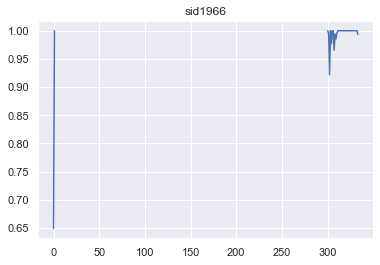

In [9]:
#plt.plot(E[0])
print(Pobs[0])
print(Eobs[0])
print(C.shape)
print(sorted([len(x) for x in D]))

for i in tqdm(range(len(sids))):
    plt.close()
    plt.plot(Pobs[i])
    plt.title(sids[i])
    plt.savefig('E_figures/%s.png'%sids[i])

# remove long gaps in data

In [10]:
ind = sids.index('sid1038') # T=1506
Pobs[ind] = Pobs[ind][1469:]
Eobs[ind] = Eobs[ind][1469:]
D[ind] = D[ind][1469:]

ind = sids.index('sid91') # T=657
Pobs[ind] = Pobs[ind][602:]
Eobs[ind] = Eobs[ind][602:]
D[ind] = D[ind][602:]

ind = sids.index('sid30') # T=453
Pobs[ind] = Pobs[ind][395:]
Eobs[ind] = Eobs[ind][395:]
D[ind] = D[ind][395:]

ind = sids.index('sid1966') # T=334
Pobs[ind] = Pobs[ind][300:]
Eobs[ind] = Eobs[ind][300:]
D[ind] = D[ind][300:]

ind = sids.index('sid395') # T=247
Pobs[ind] = Pobs[ind][196:]
Eobs[ind] = Eobs[ind][196:]
D[ind] = D[ind][196:]

ind = sids.index('sid1025') # T=245
Pobs[ind] = Pobs[ind][178:]
Eobs[ind] = Eobs[ind][178:]
D[ind] = D[ind][178:]

ind = sids.index('sid36')
Pobs[ind] = Pobs[ind][:48]
Eobs[ind] = Eobs[ind][:48]
D[ind] = D[ind][:48]

ind = sids.index('sid801')
Pobs[ind] = Pobs[ind][33:]
Eobs[ind] = Eobs[ind][33:]
D[ind] = D[ind][33:]

ind = sids.index('sid960')
Pobs[ind] = Pobs[ind][72:]
Eobs[ind] = Eobs[ind][72:]
D[ind] = D[ind][72:]

ind = sids.index('sid1006')
Pobs[ind] = Pobs[ind][47:]
Eobs[ind] = Eobs[ind][47:]
D[ind] = D[ind][47:]

ind = sids.index('sid1022')
Pobs[ind] = Pobs[ind][:39]
Eobs[ind] = Eobs[ind][:39]
D[ind] = D[ind][:39]

ind = sids.index('sid456')
Pobs[ind] = Pobs[ind][99:137]
Eobs[ind] = Eobs[ind][99:137]
D[ind] = D[ind][99:137]

ind = sids.index('sid965')
Pobs[ind] = Pobs[ind][88:]
Eobs[ind] = Eobs[ind][88:]
D[ind] = D[ind][88:]

ind = sids.index('sid915')
Pobs[ind] = Pobs[ind][93:]
Eobs[ind] = Eobs[ind][93:]
D[ind] = D[ind][93:]

print(sorted([len(x) for x in D]))

[28, 29, 34, 37, 38, 39, 48, 49, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 53, 54, 55, 55, 56, 56, 56, 56, 56, 56, 57, 57, 58, 58, 58, 58, 59, 60, 60, 61, 61, 61, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 66, 66, 67, 67, 67, 68, 68, 68, 68, 69, 70, 72, 72, 75, 75, 78, 80, 83, 83, 91, 103, 105]


# remove flat drug at the beginning or end

In [11]:
for i in range(len(sids)):
    d = D[i].sum(axis=1)
    
    start = 0
    for gi, g in enumerate(groupby(d)):
        if gi==0:
            j, k = g
            ll = len(list(k))
            if j==0:
                start = ll
        else:
            break
            
    end = 0
    for gi, g in enumerate(groupby(d[::-1])):
        if gi==0:
            j, k = g
            ll = len(list(k))
            if j==0:
                end = ll
        else:
            break
    end = len(d)-end
    
    Pobs[i] = Pobs[i][start:end]
    Eobs[i] = Eobs[i][start:end]
    D[i] = D[i][start:end]
    
print(sorted([len(x) for x in D]))

[11, 23, 23, 25, 28, 29, 29, 31, 31, 32, 33, 34, 35, 37, 37, 38, 40, 45, 45, 45, 46, 48, 48, 48, 48, 48, 48, 49, 49, 49, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 55, 56, 56, 57, 57, 57, 59, 59, 59, 60, 60, 60, 60, 60, 61, 63, 65, 65, 65, 66, 66, 66, 67, 67, 68, 68, 68, 70, 72, 77, 78, 80, 98, 102]


# make sure the first T0 points are not NaN to initialize the model

In [12]:
T0 = 2
for i in range(len(sids)):
    # move along time to find the first time when 2 points are not NaN
    found = False
    for t in range(len(D[i])-T0):
        if all([not np.isnan(Pobs[i][t+j]) for j in range(T0)]):
            found = True
            break
    if not found:
        print(sids[i], 'not found first T0 points being not NaN.')
        continue
    Eobs[i] = Eobs[i][t:]
    Pobs[i] = Pobs[i][t:]
    D[i] = D[i][t:]
    
print(sorted([len(x) for x in D]))

[11, 20, 23, 24, 25, 28, 29, 29, 31, 31, 32, 33, 34, 35, 37, 37, 38, 44, 45, 45, 45, 46, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 57, 57, 57, 58, 59, 59, 60, 60, 60, 60, 60, 64, 65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 69, 72, 73, 78, 80, 102]


# pad to same length

In [13]:
Ts = np.array([len(x) for x in D])
maxT = np.max(Ts)

for i in range(len(sids)):
    Eobs[i] = np.r_[Eobs[i], np.zeros(maxT-len(Eobs[i]), dtype=int)-1]
    Pobs[i] = np.r_[Pobs[i], np.zeros(maxT-len(Pobs[i]))+np.nan]
    D[i] = np.r_[D[i], np.zeros((maxT-len(D[i]), D[i].shape[1]))]

Eobs = np.array(Eobs)
Pobs = np.array(Pobs)
D = np.array(D)
T = D.shape[1]

print(Eobs.shape)
print(Pobs.shape)
print(D.shape)
print(C.shape)

(82, 102)
(82, 102)
(82, 102, 8)
(82, 1)


# define model

In [14]:
import pickle
from hashlib import md5

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [15]:
with open('model.stan', 'r') as f:
    pd_model = f.read()
model = StanModel_cache(model_code=pd_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ddeaf30e571bef615d368efc0e1c2e2 NOW.


# infer the model

In [ ]:
random_state = 2020

# leave one patient out cross-validation
fit_res = []
for si, sid in enumerate(sids):
    if sid!='sid1916':
        continue
    print('\n[%d/%d] %s'%(si+1, len(sids), sid))
    trids = [x for x in range(len(sids)) if sids[x]!=sid]
    Eobstr = Eobs[trids]
    Pobstr = Pobs[trids]
    Dtr = D[trids]
    Ctr = C[trids]
    Ttr = Ts[trids]
    
    teid = si
    Eobste = Eobs[teid]
    Pobste = Pobs[teid]
    Dte = D[teid]
    Cte = C[teid]
    
    Eobstr_flatten = Eobstr[:,T0:].flatten()#
    not_empty_ids = np.where(Eobstr_flatten!=-1)[0]
    not_empty_num = len(not_empty_ids)
    Eobstr_flatten_nonan = Eobstr_flatten[not_empty_ids]
    
    # generate sample weights that balances different lengths
    sample_weights = np.zeros_like(Eobstr[:,T0:]) + 1/Ttr.reshape(-1,1)#
    sample_weights = sample_weights.flatten()[not_empty_ids]
    sample_weights = sample_weights/sample_weights.mean()
    
    # standardize features
    #Cmean = Ctr.mean(axis=0)
    #Cstd = Ctr.std(axis=0)
    #Ctr = (Ctr-Cmean)/Cstd
    #Cte = (Cte-Cmean)/Cstd
    Ctr = Ctr/100
    Cte = Cte/100
    Dmax  = np.percentile(Dtr, 99)#, axis=(0,1))
    Dtr = Dtr/Dmax
    Dte = Dte/Dmax
    
    data_feed = {'W':W,
                 'N':len(Dtr),
                 'T':T,
                 'T0':T0,
                 'ND':Dtr.shape[-1],
                 'NC':Ctr.shape[-1],
                 'not_empty_num':not_empty_num,
                 'not_empty_ids':not_empty_ids+1,  # +1 for stan
                 'sample_weights':sample_weights,
                 'Eobs_flatten_nonan':Eobstr_flatten_nonan,
                 'D':Dtr.transpose(1,0,2),  # because matrix[N,ND] D[T];
                 'C':Ctr,
                 #'p_start':Pobstr[:,:T0],
                 'A_start':logit(Pobstr[:,:T0]),
                 }
    model = StanModel_cache(model_code=pd_model)
    
    """
    # use MAP to get initial value
    opt = model.optimizing(data=data_feed, iter=200, verbose=True,
                           algorithm='Newton', seed=random_state)
    def init_func():
        return {'a0':float(opt['a0']),
                'a1':float(opt['a1']),
                'a2':float(opt['a2']),
                'betaA':np.array(opt['betaA']).reshape(1),
                'b0':float(opt['b0']),
                'b':np.array(opt['b']),
                'betaB':np.array(opt['betaB']).reshape(1)}
    """
    # sampling
    fit = model.sampling(data=data_feed, iter=1000, verbose=True, chains=1, seed=random_state)
                      #init=init_func,
                      #control={'max_treedepth':9})#, 'adapt_delta':0.9})
    #print(fit)
    import pdb;pdb.set_trace()
    
    df = fit.to_dataframe(pars=['a0','a1','a2','b','beta','p', 'log_lik'])
    #plt.plot(df.a0);plt.show()
    
    # save
    df.to_csv('fit_dataframe_%s.csv'%sid, index=False)
    with open('model_fit_%s.pkl'%sid, 'wb') as f:
        pickle.dump([model, fit], f)
    """
    with open('model_fit_%s.pkl'%sid, 'rb') as f:
        model, fit = pickle.load(f)
    df = pd.read_csv('fit_dataframe_%s.csv'%sid)
    """
    fit_res.append(fit)
    
    # predict
    Epte = []
    Ppte = []
    start = len(df)//2
    for i in range(start,len(df)):
        a0 = df.a0.iloc[i]
        a1 = df.a1.iloc[i]
        a2 = df.a2.iloc[i]
        b = np.array([df['b[%d]'%(ii+1,)].iloc[i] for ii in range(7)])
        
        A = np.zeros(T)+np.nan
        for t in range(T0):
            A[t] = logit(Pobste[t])
    
        for t in range(T0, T):
            A[t] = a0 + Cte[0]*(a1*A[t-1] + a2*A[t-2] - np.dot(Dte[t], b));
        p = sigmoid(A)
        Ppte.append(p)
        Epte.append(np.random.binomial(W, p))
    Ppte = np.array(Ppte)
    Epte = np.array(Epte)
    
    Epte3 = np.percentile(Epte/W, (50,2.5,97.5), axis=0)
    
    # plot
    
    fig = plt.figure()
    ax1=fig.add_subplot(211)
    ax1.plot(Epte3.T,c='r')
    ax1.plot(Pobste,c='k')
    ax2=fig.add_subplot(212)
    ax2.plot(Dte*Dmax)
    plt.show()

In [ ]:
#TODO
"""
drugs_used = np.where(np.sum(D,axis=1)!=0)[0]
print(drugs_used)
fig,ax = plt.subplots(1+len(drugs_used),1,sharex=True,figsize=(15,10),gridspec_kw = {'height_ratios':[10]+[1 for i in range(len(drugs_used))]})
ax[0].plot(np.arange(2,T),Eobs1[2:],c='black',label='Observed')
ax[0].plot(np.arange(2,T),p.mean(axis=0)[2:],c='red',label='Simulated')
ax[0].fill_between(x=np.arange(2,T),y1=p.mean(axis=0)[2:]+p.std(axis=0)[2:],y2=p.mean(axis=0)[2:]-p.std(axis=0)[2:],alpha=0.25,color='red')
ax[0].legend()
ax[0].set_title('IIC Ratio %s'%('sid1916'))
for i in range(1,1+len(drugs_used)):
        y = D[drugs_used[i-1],:]
        ax[i].imshow(y[np.newaxis,:], cmap="plasma", aspect="auto")
        ax[i].set_title(halflife.keys()[drugs_used[i-1]])
"""